# Libs

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import os

# Leitura dos dados

In [2]:
# Caminho da pasta
pasta = r'C:\Users\feh_s\case_wiz_co\data\novos_dados'

# Lista todos os arquivos na pasta
arquivos = os.listdir(pasta)

# Loop para ler cada arquivo e atribuir o nome do dataframe
for arquivo in arquivos:
    # Verifica se o arquivo é um arquivo CSV (ou ajuste para o formato correto, se necessário)
    if arquivo.endswith('.csv'):
        # Extrai o nome do arquivo sem a extensão para atribuir como nome do dataframe
        nome_dataframe = os.path.splitext(arquivo)[0]
        
        # Lê o arquivo e atribui ao dataframe com o nome correspondente
        caminho_completo = os.path.join(pasta, arquivo)
        globals()[nome_dataframe] = pd.read_csv(caminho_completo, encoding='utf-8', sep=';')
        print(nome_dataframe)


receitas
vendas


# Informações iniciais sobre os dados

In [3]:
receitas.head()

,ano,mes,seguradora,vendedor,tot_apolices,receita
0,2019,1,72,58,1,"65,3"
1,2019,1,72,57,4,"1360,235"
2,2019,1,72,56,3,"276,49"
3,2019,1,72,47,2,"-1707,095"
4,2019,1,72,38,3,"1080,745"


In [4]:
vendas.head()

,ano,mes,seguradora,vendedor,tot_apolices,venda
0,2019,1,66,1,1,"174,055"
1,2019,1,31,58,1,"92,31"
2,2019,1,72,35,6,"900,08"
3,2019,1,55,20,1,7550
4,2019,1,72,58,2,"84,175"


In [5]:
dataframes = [receitas, vendas]
for df in dataframes:
    print("Informações do DataFrame:")
    print(df.info())
    print("-"*50)

Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ano           1080 non-null   int64 
 1   mes           1080 non-null   int64 
 2   seguradora    1080 non-null   int64 
 3   vendedor      1080 non-null   int64 
 4   tot_apolices  1080 non-null   int64 
 5   receita       1080 non-null   object
dtypes: int64(5), object(1)
memory usage: 50.8+ KB
None
--------------------------------------------------
Informações do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1242 entries, 0 to 1241
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ano           1242 non-null   int64 
 1   mes           1242 non-null   int64 
 2   seguradora    1242 non-null   int64 
 3   vendedor      1242 non-null   int64 
 4   tot_apolices  1242 non-null   int64 

# Limpeza dos dados

In [6]:
def extrair_valor_monetario(df, colunas):
    for coluna in colunas:
        df[coluna] = df[coluna].str.replace('.', '').str.replace(',', '.').astype(float)
    return df

In [7]:
def extrair_valor_monetario(df, colunas):
    df[colunas] = df[colunas].apply(lambda x: x.str.replace('.', '').str.replace(',', '.').astype(float))
    return df

In [8]:
print(vendas.columns)
print(receitas.columns)

Index(['ano', 'mes', 'seguradora', 'vendedor', 'tot_apolices', 'venda'], dtype='object')
Index(['ano', 'mes', 'seguradora', 'vendedor', 'tot_apolices', 'receita'], dtype='object')


## Colunas de seguradora e vendedor para string

In [9]:
receitas[['seguradora', 'vendedor']] = receitas[['seguradora', 'vendedor']].applymap(str)
vendas[['seguradora', 'vendedor']] = vendas[['seguradora', 'vendedor']].applymap(str)


## Valores nulos coluna de venda/receita para int

In [10]:
# vendas.loc[:, 'venda'] = vendas['venda'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
receitas.loc[:, 'receita'] = receitas['receita'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
receitas['receita'] = pd.to_numeric(receitas['receita'])

In [11]:
receitas['receita'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1080 entries, 0 to 1079
Series name: receita
Non-Null Count  Dtype  
--------------  -----  
1080 non-null   float64
dtypes: float64(1)
memory usage: 8.6 KB


In [9]:
vendas_is_null = vendas.loc[vendas['venda'].isnull()]
vendas_is_null

,ano,mes,seguradora,vendedor,tot_apolices,venda
56,2019,1,81,2,1,NaN
95,2019,2,81,2,1,NaN
584,2019,9,68,22,1,NaN
763,2019,12,77,2,1,NaN


In [12]:
venda_not_null = vendas[~vendas['venda'].isnull()]
# venda_not_null['venda'] = venda_not_null['venda'].str.replace(',', '.').astype('float')
venda_not_null.loc[:, 'venda'] = venda_not_null['venda'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
venda_not_null['venda'] = pd.to_numeric(venda_not_null['venda'])

C:\Users\feh_s\AppData\Local\Temp\ipykernel_22736\311048895.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  venda_not_null['venda'] = pd.to_numeric(venda_not_null['venda'])


In [15]:
venda_not_null.loc[venda_not_null['vendedor'] == '2']

,ano,mes,seguradora,vendedor,tot_apolices,venda
19,2019,1,66,2,1,87.175
37,2019,1,72,2,3,485.390
43,2019,1,31,2,1,2389.950
70,2019,2,66,2,1,262.795
153,2019,3,81,2,1,1115.910
334,2019,6,72,2,1,354.735
361,2019,6,74,2,1,58.350
373,2019,6,66,2,1,75.005
403,2019,7,66,2,2,130.875
440,2019,7,72,2,4,56.030


In [17]:
print(
    venda_not_null
    .loc[
        (venda_not_null['vendedor'] == '2')
        & (venda_not_null['ano'] == 2019)
        & (venda_not_null['mes'] == 1)
        ]
    .groupby('vendedor')['venda']
    .mean()
)

print(
    venda_not_null
    .loc[
        (venda_not_null['vendedor'] == '2')
        & (venda_not_null['ano'] == 2019)
        & (venda_not_null['mes'] == 2)
        ]
    .groupby('vendedor')['venda']
    .mean()
)

print(
    venda_not_null
    .loc[
        (venda_not_null['vendedor'] == '22')
        & (venda_not_null['ano'] == 2019)
        & (venda_not_null['mes'] == 9)
        ]
    .groupby('vendedor')['venda']
    .mean()
)

print(
    venda_not_null
    .loc[
        (venda_not_null['vendedor'] == '2')
        & (venda_not_null['ano'] == 2019)
        & (venda_not_null['mes'] == 12)
        ]
    .groupby('vendedor')['venda']
    .mean()
)

vendedor
2    987.505
Name: venda, dtype: float64
vendedor
2    262.795
Name: venda, dtype: float64
vendedor
22    156.1275
Name: venda, dtype: float64
vendedor
2    221.8575
Name: venda, dtype: float64


In [18]:
vendas.loc[vendas['venda'].isnull()]

,ano,mes,seguradora,vendedor,tot_apolices,venda
56,2019,1,81,2,1,NaN
95,2019,2,81,2,1,NaN
584,2019,9,68,22,1,NaN
763,2019,12,77,2,1,NaN


In [19]:
vendas.loc[56, 'venda'] = '987,505'
vendas.loc[95, 'venda'] = '262,795'
vendas.loc[584, 'venda'] = '156,1275'
vendas.loc[763, 'venda'] = '221,8575'

In [20]:
vendas.loc[:, 'venda'] = vendas['venda'].apply(lambda x: float(x.replace('.', '').replace(',', '.')))
vendas['venda'] = pd.to_numeric(vendas['venda'])
vendas.head()

,ano,mes,seguradora,vendedor,tot_apolices,venda
0,2019,1,66,1,1,174.055
1,2019,1,31,58,1,92.310
2,2019,1,72,35,6,900.080
3,2019,1,55,20,1,7550.000
4,2019,1,72,58,2,84.175


## Criando colunas datetime 

In [21]:
receitas['date'] = pd.to_datetime(receitas['ano'].astype(str) + '-' + receitas['mes'].astype(str), format='%Y-%m')
vendas['date'] = pd.to_datetime(vendas['ano'].astype(str) + '-' + vendas['mes'].astype(str), format='%Y-%m')

In [22]:
receitas

,ano,mes,seguradora,vendedor,tot_apolices,receita,date
0,2019,1,72,58,1,65.300,2019-01-01
1,2019,1,72,57,4,1360.235,2019-01-01
2,2019,1,72,56,3,276.490,2019-01-01
3,2019,1,72,47,2,-1707.095,2019-01-01
4,2019,1,72,38,3,1080.745,2019-01-01
...,...,...,...,...,...,...,...
1075,2020,6,72,14,1,98.935,2020-06-01
1076,2020,6,72,13,3,3244.695,2020-06-01
1077,2020,6,72,12,3,267.235,2020-06-01
1078,2020,6,72,9,12,2157.955,2020-06-01


## Coluna de total venda/receita

In [23]:
vendas['tot_vendas'] = vendas['tot_apolices'] * vendas['venda']
receitas['tot_receita'] = receitas['tot_apolices'] * receitas['receita']

# Análise exploratória

In [34]:
receitas.describe()

,ano,mes,tot_apolices,receita,date,tot_receita
count,1080.000000,1080.000000,1080.00000,1080.000000,1080,1080.000000
mean,2019.352778,5.695370,3.32963,1201.460574,2019-09-28 22:51:59.999999744,5426.334954
min,2019.000000,1.000000,1.00000,-4622.065000,2019-01-01 00:00:00,-40964.000000
25%,2019.000000,3.000000,1.00000,109.560000,2019-06-01 00:00:00,144.767500
50%,2019.000000,5.000000,2.00000,309.747500,2019-10-01 00:00:00,668.162500
75%,2020.000000,8.000000,4.00000,959.635000,2020-02-01 00:00:00,3315.712500
max,2020.000000,12.000000,34.00000,125950.595000,2020-06-01 00:00:00,215018.040000
std,0.478056,3.195626,3.61808,4632.482693,NaN,15838.419240


In [33]:
vendas.describe()

,ano,mes,tot_apolices,venda,date,tot_vendas
count,1242.000000,1242.000000,1242.000000,1242.000000,1242,1242.000000
mean,2019.359903,5.566023,3.416264,1262.376864,2019-09-27 15:44:55.652174080,6471.948921
min,2019.000000,1.000000,1.000000,-61874.485000,2019-01-01 00:00:00,-232804.470000
25%,2019.000000,3.000000,1.000000,92.590000,2019-06-01 00:00:00,116.263750
50%,2019.000000,5.000000,2.000000,254.617500,2019-10-01 00:00:00,546.947500
75%,2020.000000,8.000000,4.000000,842.583750,2020-02-01 00:00:00,2993.902500
max,2020.000000,12.000000,36.000000,148598.290000,2020-06-01 00:00:00,891589.740000
std,0.480165,3.261018,3.798065,6876.339591,NaN,34681.789944


## Qual a distribuição de apolices e receitas/vendas?

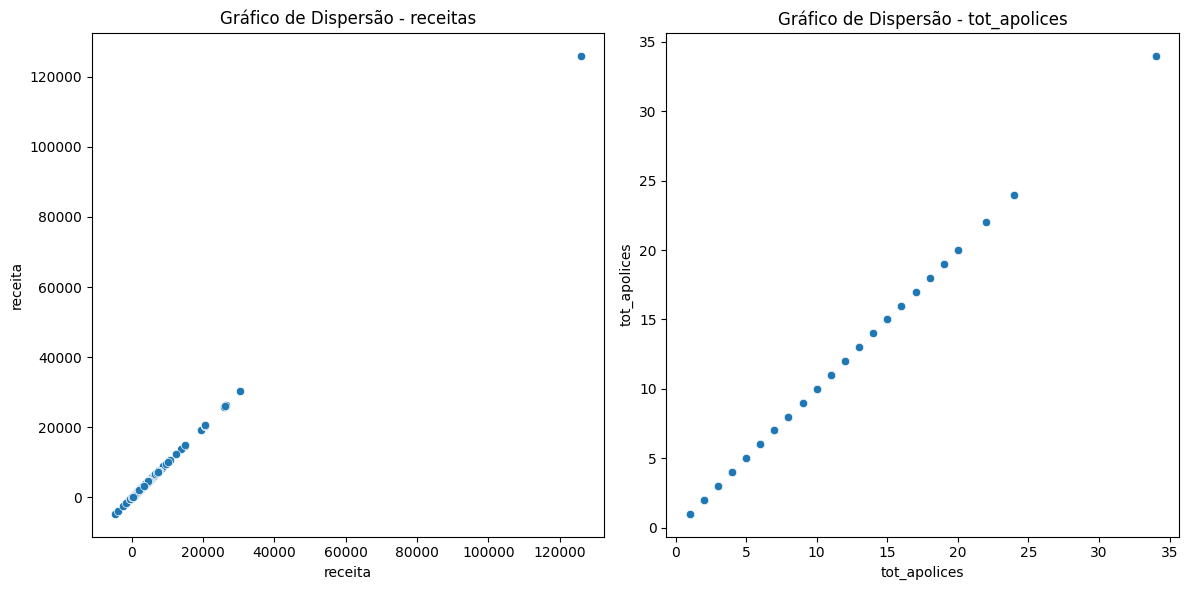

In [37]:
# Criando subplots (1 linha e 2 colunas)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de dispersão 1
sns.scatterplot(x='receita', y='receita', data=receitas, ax=axs[0])
axs[0].set_title('Gráfico de Dispersão - receitas')
axs[0].set_xlabel('receita')
axs[0].set_ylabel('receita')

# Gráfico de dispersão 2
sns.scatterplot(x='tot_apolices', y='tot_apolices', data=receitas, ax=axs[1])
axs[1].set_title('Gráfico de Dispersão - tot_apolices')
axs[1].set_xlabel('tot_apolices')
axs[1].set_ylabel('tot_apolices')

# Ajustando o espaçamento entre os subplots e exibindo o gráfico
plt.tight_layout()
plt.show()


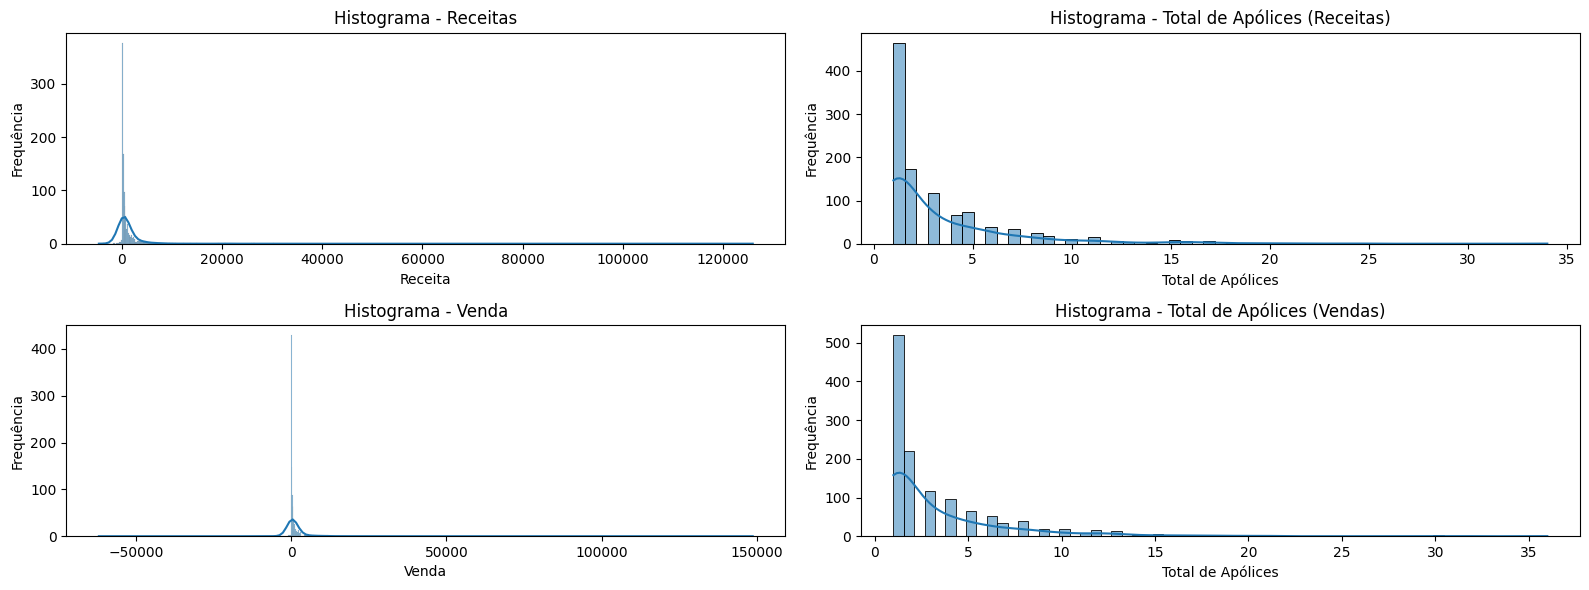

In [43]:
# Criando subplots (1 linha e 2 colunas)
fig, axs = plt.subplots(2, 2, figsize=(16, 6))

# Histograma receitas
sns.histplot(data=receitas, x='receita', ax=axs[0, 0], kde=True)
axs[0, 0].set_title('Histograma - Receitas')
axs[0, 0].set_xlabel('Receita')
axs[0, 0].set_ylabel('Frequência')

# Histograma apolices de receitas
sns.histplot(data=receitas, x='tot_apolices', ax=axs[0, 1], kde=True)
axs[0, 1].set_title('Histograma - Total de Apólices (Receitas)')
axs[0, 1].set_xlabel('Total de Apólices')
axs[0, 1].set_ylabel('Frequência')

# Histograma vendas
sns.histplot(data=vendas, x='venda', ax=axs[1, 0], kde=True)
axs[1, 0].set_title('Histograma - Venda')
axs[1, 0].set_xlabel('Venda')
axs[1, 0].set_ylabel('Frequência')

# Histograma apolices de vendas
sns.histplot(data=vendas, x='tot_apolices', ax=axs[1, 1], kde=True)
axs[1, 1].set_title('Histograma - Total de Apólices (Vendas)')
axs[1, 1].set_xlabel('Total de Apólices')
axs[1, 1].set_ylabel('Frequência')

# Ajustando o espaçamento entre os subplots e exibindo o gráfico
plt.tight_layout()
plt.show()


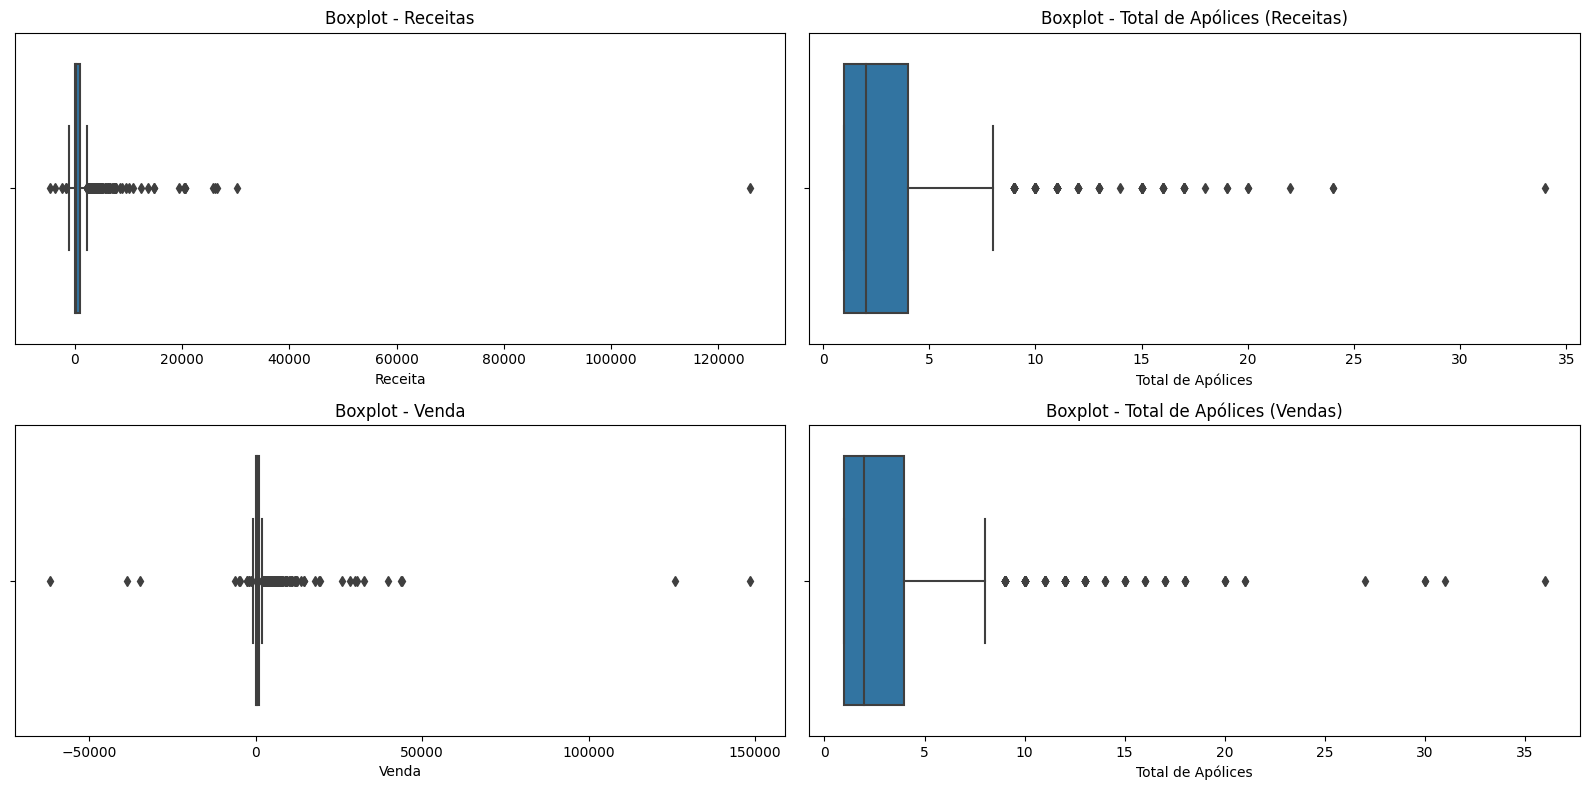

In [44]:
# Criando subplots (1 linha e 2 colunas)
fig, axs = plt.subplots(2, 2, figsize=(16, 8))

# Boxplot receitas
sns.boxplot(data=receitas, x='receita', ax=axs[0, 0])
axs[0, 0].set_title('Boxplot - Receitas')
axs[0, 0].set_xlabel('Receita')

# Boxplot apolices de receitas
sns.boxplot(data=receitas, x='tot_apolices', ax=axs[0, 1])
axs[0, 1].set_title('Boxplot - Total de Apólices (Receitas)')
axs[0, 1].set_xlabel('Total de Apólices')

# Boxplot vendas
sns.boxplot(data=vendas, x='venda', ax=axs[1, 0])
axs[1, 0].set_title('Boxplot - Venda')
axs[1, 0].set_xlabel('Venda')

# Boxplot apolices de vendas
sns.boxplot(data=vendas, x='tot_apolices', ax=axs[1, 1])
axs[1, 1].set_title('Boxplot - Total de Apólices (Vendas)')
axs[1, 1].set_xlabel('Total de Apólices')

# Ajustando o espaçamento entre os subplots e exibindo o gráfico
plt.tight_layout()
plt.show()


### Não tem como saber, apenas olhando para os dados, se esses outliars estão corretos ou não, mas tenho que tomar cuidado ao utilizar a média desses valores. Porque eles puxam a estatística muito para cima.

## Vendas vs Receitas

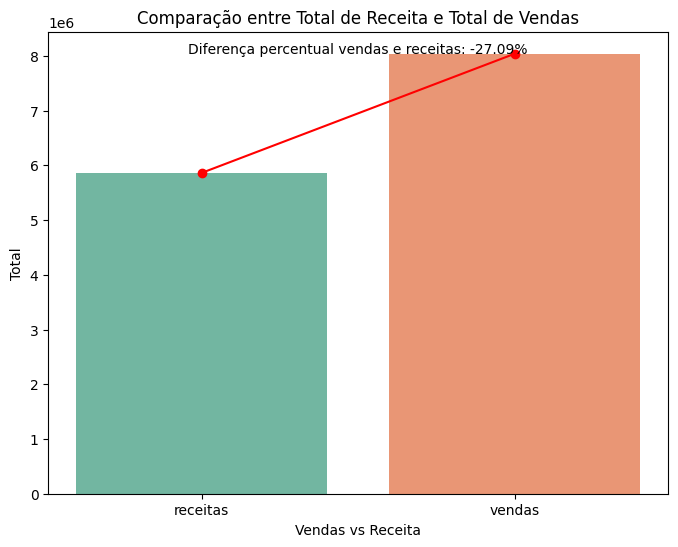

In [65]:
# Criar um novo DataFrame para consolidar os dados
data = {
    'DataFrame': ['receitas', 'vendas'],
    'Total': [receitas['tot_receita'].sum(), vendas['tot_vendas'].sum()]
}
df_total = pd.DataFrame(data)

# Calcular a diferença percentual entre as duas barras
total_receita = receitas['tot_receita'].sum()
total_vendas = vendas['tot_vendas'].sum()
diff_percent = ((total_receita - total_vendas) / total_vendas) * 100


# Criar o gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='DataFrame', y='Total', data=df_total, palette='Set2')

# Adicionar a linha conectando as colunas
plt.plot([0, 1], [total_receita, total_vendas], marker='o', color='red')

# Adicionar texto com a diferença percentual
plt.text(0.5, max(total_receita, total_vendas), f'Diferença percentual vendas e receitas: {diff_percent:.2f}%', ha='center')

# Configurações do gráfico
plt.xlabel('Vendas vs Receita')
plt.ylabel('Total')
plt.title('Comparação entre Total de Receita e Total de Vendas')
plt.show()


## Total de receita/venda por ano

In [66]:
receitas.groupby('ano')['receita'].sum().reset_index()

,ano,receita
0,2019,747908.20
1,2020,549669.22


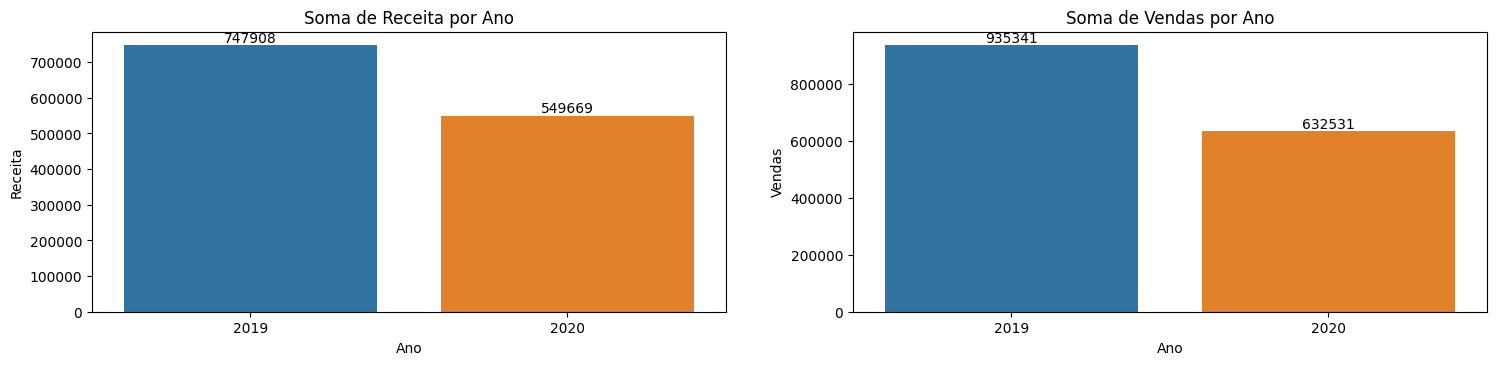

In [54]:
plt.figure(figsize=(18,8))
plt.tight_layout(pad=1.15, h_pad=1.5, w_pad=1.15, rect=None)

# Plotar gráfico usando Seaborn
group_receitas = receitas.groupby('ano')['receita'].sum().reset_index()

plt.subplot(221)
ax1 = sns.barplot(x='ano', y='receita', data=group_receitas, errwidth=0)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Receita')
plt.title('Soma de Receita por Ano')

# Exibir o gráfico
for container in ax1.containers:
    ax1.bar_label(container)

# Gráfico de vendas
group_vendas = vendas.groupby('ano')['venda'].sum().reset_index()

plt.subplot(222)
ax2 = sns.barplot(x='ano', y='venda', data=group_vendas, errwidth=0)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Vendas')
plt.title('Soma de Vendas por Ano')

# Exibir o gráfico
for container in ax2.containers:
    ax2.bar_label(container)

## Total de vendas e receitas no primeiro semestre

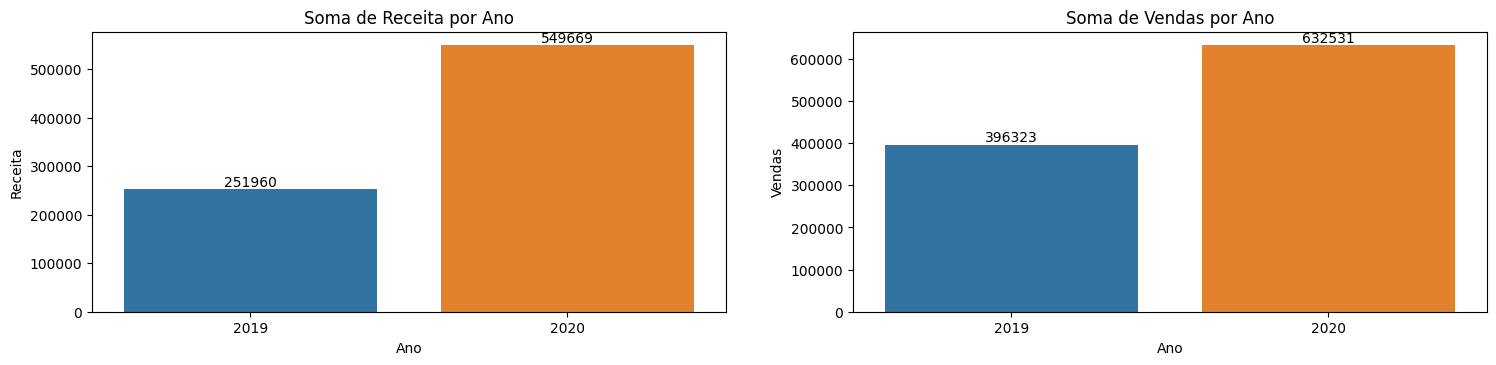

In [56]:
plt.figure(figsize=(18,8))
plt.tight_layout(pad=1.15, h_pad=1.5, w_pad=1.15, rect=None)

# Plotar gráfico usando Seaborn
group_receitas = receitas.loc[receitas['mes']<=6].groupby('ano')['receita'].sum().reset_index()

plt.subplot(221)
ax1 = sns.barplot(x='ano', y='receita', data=group_receitas, errwidth=0)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Receita')
plt.title('Soma de Receita por Ano')

# Exibir o gráfico
for container in ax1.containers:
    ax1.bar_label(container)

# Gráfico de vendas
group_vendas = vendas.loc[vendas['mes']<=6].groupby('ano')['venda'].sum().reset_index()

plt.subplot(222)
ax2 = sns.barplot(x='ano', y='venda', data=group_vendas, errwidth=0)

# Configurações do gráfico
plt.xlabel('Ano')
plt.ylabel('Vendas')
plt.title('Soma de Vendas por Ano')

# Exibir o gráfico
for container in ax2.containers:
    ax2.bar_label(container)

# O primeiro semestre de 2020 é bem melhor que o de 2019

## Vendas e receitas por mês

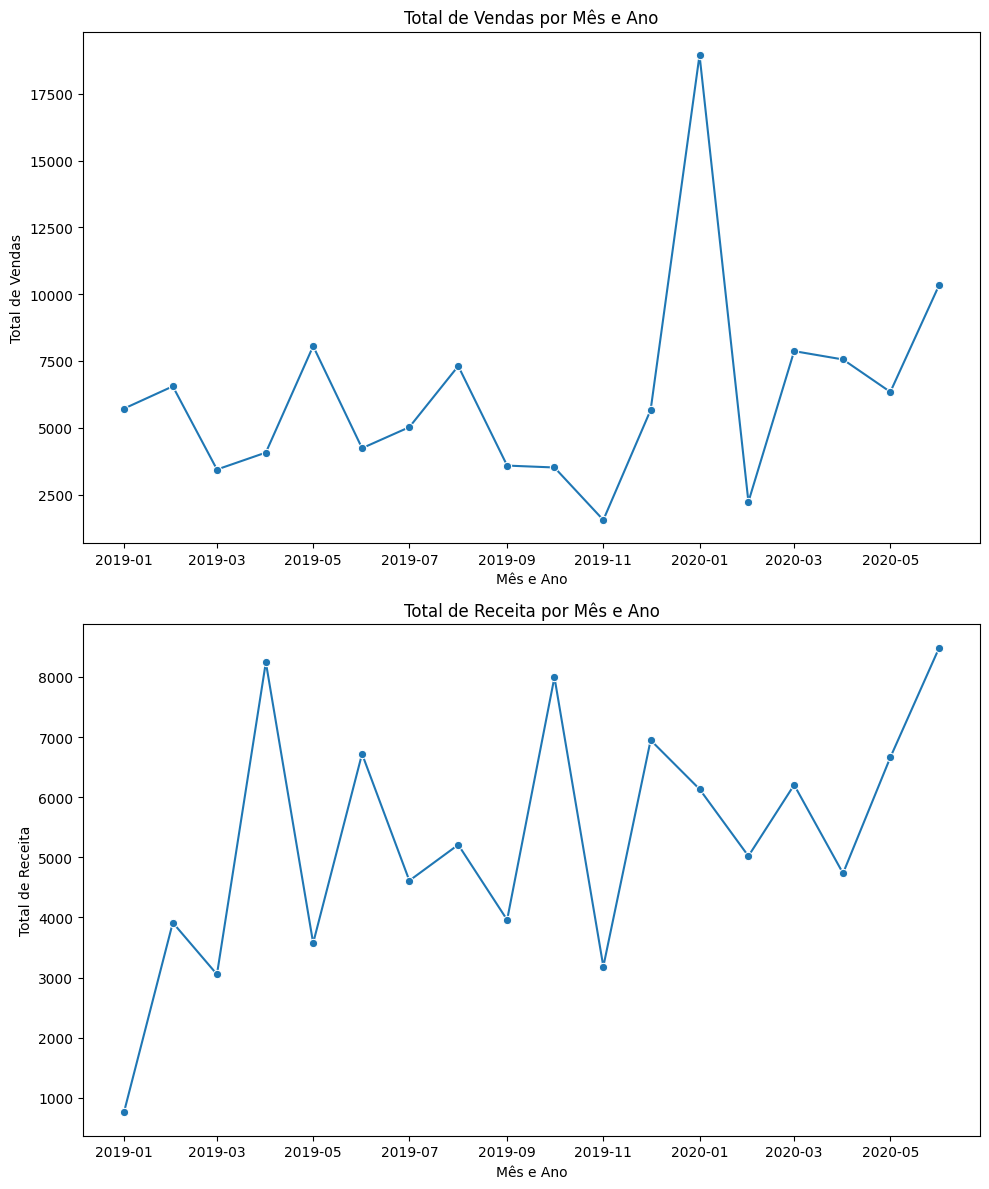

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

# Criar subplots (2 linhas e 1 coluna)
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico de linhas para 'tot_venda'
sns.lineplot(x='date', y='tot_vendas', data=vendas, ax=axs[0], marker='o', errorbar=None)
axs[0].set_title('Total de Vendas por Mês e Ano')
axs[0].set_xlabel('Mês e Ano')
axs[0].set_ylabel('Total de Vendas')
# axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y-%m')))

# Gráfico de linhas para 'tot_receita'
sns.lineplot(x='date', y='tot_receita', data=receitas, ax=axs[1], marker='o', errorbar=None)
axs[1].set_title('Total de Receita por Mês e Ano')
axs[1].set_xlabel('Mês e Ano')
axs[1].set_ylabel('Total de Receita')
# axs[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: pd.to_datetime(x).strftime('%Y-%m')))

# Ajustar layout e exibir o gráfico
plt.tight_layout()
plt.show()
